In [1]:
# pip install --upgrade tensorflow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import he_uniform
from tqdm import tqdm

print(tf.__version__)

2.0.0


#### Load, convert and check data

In [3]:
# Read the data
# csv_train_file = pd.read_csv('./siim-isic-melanoma-classification/train.csv')
# csv_test_file = pd.read_csv('./siim-isic-melanoma-classification/test.csv')

# Pre-processed data files
X_train_load = pd.read_csv('./cleaned_csvs/train_pp.csv')
X_test_load = pd.read_csv('./cleaned_csvs/test_pp.csv')

X_train_pp = X_train_load.copy()
X_test_pp = X_test_load.copy()

# Drop the image names from the tabular data
X_train_pp.drop(['image_name'], axis=1, inplace=True)
X_test_pp.drop(['image_name'], axis=1, inplace=True)

# Separate target from predictors
y_train = X_train_pp.target
X_train_pp.drop(['target'], axis=1, inplace=True)

In [4]:
print(f'Number of Training Examples = {X_train_pp.shape[0]}')
print(f'Number of Test Examples = {X_test_pp.shape[0]}\n')

print("X_train_pp.shape:", X_train_pp.shape)
print("X_test_pp.shape:", X_test_pp.shape)
print("y_train.shape:", y_train.shape)

Number of Training Examples = 33126
Number of Test Examples = 10982

X_train_pp.shape: (33126, 15)
X_test_pp.shape: (10982, 15)
y_train.shape: (33126,)


In [5]:
display(X_train_pp.head(10))

,age_approx,age_id_min,age_id_max,n_images,image_size_scaled,sex_female,sex_male,sex_missing_value,anatom_site_general_challenge_head/neck,anatom_site_general_challenge_lower extremity,anatom_site_general_challenge_missing_value,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_upper extremity
0,-0.259359,-0.093567,-0.422722,3.433045,1.760172,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.259359,-0.093567,-0.422722,-0.301802,1.877304,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.084646,0.239713,0.280969,-1.081605,-1.058326,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.259359,-0.426847,-0.422722,-0.383886,-0.930443,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.428651,0.572993,0.280969,-0.465971,1.444067,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,-0.603364,-0.426847,-0.774568,1.134678,0.778175,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,-1.635380,-1.426688,-1.478259,-0.383886,0.739172,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,-0.947369,-0.760128,-0.774568,-0.096590,-0.688747,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,-1.291374,-1.093408,-1.478259,0.149663,0.461915,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.084646,0.239713,-0.070877,-0.342844,0.716244,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Tabular Data

In [6]:
# Convert training and test tabular data to numpy arrays
X_train_pp_np = np.array(X_train_pp, dtype="float32")
X_test_pp_np = np.array(X_test_pp, dtype="float32")
targets = np.array(y_train, dtype="uint8")

In [7]:
print("X_train_pp_np.shape:", X_train_pp_np.shape)
print("X_test_pp_np.shape:", X_test_pp_np.shape)
print("targets.shape:", targets.shape)

X_train_pp_np.shape: (33126, 15)
X_test_pp_np.shape: (10982, 15)
targets.shape: (33126,)


#### Build The Tabular Data ANN Model

In [8]:
# Prepare Validation Set (Using 20% held back for validation)
num_val_samples = int(len(X_train_pp_np) * 0.20)
train_features = X_train_pp_np[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = X_train_pp_np[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))
print("Number of training targets:", len(train_targets))
print("Number of validation targets:", len(val_targets))

Number of training samples: 26501
Number of validation samples: 6625
Number of training targets: 26501
Number of validation targets: 6625


In [9]:
# Analyze class imbalance in the targets
counts = np.bincount(train_targets[:])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 470 (1.77% of total)


In [10]:
# Build a binary classification model
relu_initializer = he_uniform(seed=1)

ann_model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],), kernel_initializer=relu_initializer
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation="relu", kernel_initializer=relu_initializer),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation="relu", kernel_initializer=relu_initializer),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
ann_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4096      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

In [11]:
# Train the model with class_weight argument
ann_filepath = './trained_weights/ann/'

metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc")
]

ann_model.compile(
    optimizer=Adam(0.002), loss="binary_crossentropy", metrics=metrics
)

callbacks = [ModelCheckpoint(ann_filepath+"identification_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

history_ann = ann_model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=100,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)

Train on 26501 samples, validate on 6625 samples
Epoch 1/100
26501/26501 - 4s - loss: 7.7210e-05 - fn: 204.0000 - fp: 11645.0000 - tn: 14386.0000 - tp: 266.0000 - precision: 0.0223 - recall: 0.5660 - auc: 0.5951 - val_loss: 4.1799e-05 - val_fn: 33.0000 - val_fp: 2308.0000 - val_tn: 4203.0000 - val_tp: 81.0000 - val_precision: 0.0339 - val_recall: 0.7105 - val_auc: 0.7789
Epoch 2/100
26501/26501 - 1s - loss: 6.2609e-05 - fn: 187.0000 - fp: 9158.0000 - tn: 16873.0000 - tp: 283.0000 - precision: 0.0300 - recall: 0.6021 - auc: 0.6793 - val_loss: 4.4583e-05 - val_fn: 10.0000 - val_fp: 3429.0000 - val_tn: 3082.0000 - val_tp: 104.0000 - val_precision: 0.0294 - val_recall: 0.9123 - val_auc: 0.7883
Epoch 3/100
26501/26501 - 1s - loss: 5.1879e-05 - fn: 152.0000 - fp: 9189.0000 - tn: 16842.0000 - tp: 318.0000 - precision: 0.0334 - recall: 0.6766 - auc: 0.7221 - val_loss: 3.9985e-05 - val_fn: 19.0000 - val_fp: 2608.0000 - val_tn: 3903.0000 - val_tp: 95.0000 - val_precision: 0.0351 - val_recall: 0.

Epoch 27/100
26501/26501 - 1s - loss: 4.0673e-05 - fn: 104.0000 - fp: 9564.0000 - tn: 16467.0000 - tp: 366.0000 - precision: 0.0369 - recall: 0.7787 - auc: 0.7948 - val_loss: 3.8159e-05 - val_fn: 29.0000 - val_fp: 2256.0000 - val_tn: 4255.0000 - val_tp: 85.0000 - val_precision: 0.0363 - val_recall: 0.7456 - val_auc: 0.8174
Epoch 28/100
26501/26501 - 1s - loss: 4.1145e-05 - fn: 106.0000 - fp: 9447.0000 - tn: 16584.0000 - tp: 364.0000 - precision: 0.0371 - recall: 0.7745 - auc: 0.7897 - val_loss: 3.8076e-05 - val_fn: 28.0000 - val_fp: 2260.0000 - val_tn: 4251.0000 - val_tp: 86.0000 - val_precision: 0.0367 - val_recall: 0.7544 - val_auc: 0.8181
Epoch 29/100
26501/26501 - 1s - loss: 4.0936e-05 - fn: 95.0000 - fp: 10170.0000 - tn: 15861.0000 - tp: 375.0000 - precision: 0.0356 - recall: 0.7979 - auc: 0.7963 - val_loss: 3.8149e-05 - val_fn: 27.0000 - val_fp: 2155.0000 - val_tn: 4356.0000 - val_tp: 87.0000 - val_precision: 0.0388 - val_recall: 0.7632 - val_auc: 0.8182
Epoch 30/100
26501/26501 

Epoch 53/100
26501/26501 - 1s - loss: 3.9529e-05 - fn: 102.0000 - fp: 7851.0000 - tn: 18180.0000 - tp: 368.0000 - precision: 0.0448 - recall: 0.7830 - auc: 0.8215 - val_loss: 3.6904e-05 - val_fn: 36.0000 - val_fp: 1479.0000 - val_tn: 5032.0000 - val_tp: 78.0000 - val_precision: 0.0501 - val_recall: 0.6842 - val_auc: 0.8249
Epoch 54/100
26501/26501 - 1s - loss: 3.8849e-05 - fn: 100.0000 - fp: 8581.0000 - tn: 17450.0000 - tp: 370.0000 - precision: 0.0413 - recall: 0.7872 - auc: 0.8142 - val_loss: 3.6917e-05 - val_fn: 37.0000 - val_fp: 1632.0000 - val_tn: 4879.0000 - val_tp: 77.0000 - val_precision: 0.0451 - val_recall: 0.6754 - val_auc: 0.8277
Epoch 55/100
26501/26501 - 1s - loss: 3.8999e-05 - fn: 113.0000 - fp: 8364.0000 - tn: 17667.0000 - tp: 357.0000 - precision: 0.0409 - recall: 0.7596 - auc: 0.8158 - val_loss: 3.7042e-05 - val_fn: 38.0000 - val_fp: 1512.0000 - val_tn: 4999.0000 - val_tp: 76.0000 - val_precision: 0.0479 - val_recall: 0.6667 - val_auc: 0.8295
Epoch 56/100
26501/26501 

Epoch 79/100
26501/26501 - 1s - loss: 3.8033e-05 - fn: 109.0000 - fp: 7824.0000 - tn: 18207.0000 - tp: 361.0000 - precision: 0.0441 - recall: 0.7681 - auc: 0.8258 - val_loss: 3.6288e-05 - val_fn: 36.0000 - val_fp: 1500.0000 - val_tn: 5011.0000 - val_tp: 78.0000 - val_precision: 0.0494 - val_recall: 0.6842 - val_auc: 0.8358
Epoch 80/100
26501/26501 - 1s - loss: 3.7371e-05 - fn: 101.0000 - fp: 8007.0000 - tn: 18024.0000 - tp: 369.0000 - precision: 0.0441 - recall: 0.7851 - auc: 0.8336 - val_loss: 3.6232e-05 - val_fn: 38.0000 - val_fp: 1418.0000 - val_tn: 5093.0000 - val_tp: 76.0000 - val_precision: 0.0509 - val_recall: 0.6667 - val_auc: 0.8370
Epoch 81/100
26501/26501 - 1s - loss: 3.8423e-05 - fn: 99.0000 - fp: 8076.0000 - tn: 17955.0000 - tp: 371.0000 - precision: 0.0439 - recall: 0.7894 - auc: 0.8272 - val_loss: 3.6258e-05 - val_fn: 35.0000 - val_fp: 1488.0000 - val_tn: 5023.0000 - val_tp: 79.0000 - val_precision: 0.0504 - val_recall: 0.6930 - val_auc: 0.8362
Epoch 82/100
26501/26501 -

In [12]:
# Determine AUC score
# Pick out the history data that we want
auc = history_ann.history['auc']
val_auc = history_ann.history['val_auc']
loss = history_ann.history['loss']
val_loss = history_ann.history['val_loss']
epochs = range(len(auc))

train_auc = auc[-1]
print("Train AUC: ",train_auc)

test_auc = val_auc[-1]
print("Test AUC: ",test_auc)

Train AUC:  0.8393627
Test AUC:  0.83436996


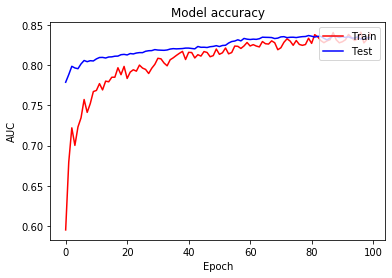

In [13]:
# Plot training & validation accuracy values
plt.plot(epochs, auc, 'r')
plt.plot(epochs, val_auc, 'b')
plt.title('Model accuracy')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [14]:
# Save test predictions to file
preds_test = ann_model.predict(X_test_pp_np)

# Use .ravel() to flatten from 10982,1 to 10982,
output = pd.DataFrame({'image_name': X_test_load.image_name,
                       'target': preds_test.ravel()})
output.to_csv('./predictions/csv_only_submission_ann.csv', index=False)